## Topic Modelling

In [1]:
import pandas as pd
import nltk; nltk.download('stopwords')

import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
# import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
#warnings.filterwarnings("ignore",category=DeprecationWarning)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/beatricebiancabencio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### 1. Import data

In [2]:
df = pd.read_csv('/Users/beatricebiancabencio/Desktop/Eskwelabs/df_criminal_casetitleXcontent.csv')
df

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,case_title,case_type,tag_1,tag_2,gr_no,case_type_total,case_type_count,content,content_clean,wordcount,tokenized,tokenized_2,lemmatized,lemmatized_clean,case_title_clean,case_title_tokenized,case_title_lemmatized,case_title_lemmatized_clean,case_title_lemmatized_clean_stopwords,test
0,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...",CRIMINAL,NaN,NaN,G.R. No. 122290,['CRIMINAL'],1,"FIRST DIVISION G.R. No. 122290, April 06, 200...",Appellant REYNALDO BAGO was charged with quali...,7952,"['Appellant', 'REYNALDO', 'BAGO', 'wa', 'charg...","['appellant', 'reynaldo', 'bago', 'wa', 'charg...",appellant reynaldo bago wa charged with qualif...,appellant reynaldo bago wa charged qualified t...,"PEOPLE OF THE PHILIPPINES, PLAINTIFF-APPELLEE,...","['people', 'of', 'the', 'philippines', 'reynal...","['people', 'of', 'the', 'philippines', 'reynal...",people of the philippines reynaldo bago y madr...,people philippines reynaldo bago y madrid arma...,people philippines reynaldo bago y madrid arma...
1,"TONY N. FIGUEROA AND ROGELIO J. FLAVIANO, PETI...",CRIMINAL,NaN,NaN,G.R. NO. 159813,['CRIMINAL'],1,"SECOND DIVISION G.R. NO. 159813, August 09, 2...",Assailed and sought to be set aside in this pe...,2641,"['Assailed', 'and', 'sought', 'to', 'be', 'set...","['assailed', 'and', 'sought', 'to', 'be', 'set...",assailed and sought to be set aside in this pe...,assailed sought set aside petition review rule...,"TONY N. FIGUEROA AND ROGELIO J. FLAVIANO, PETI...","['tony', 'figueroa', 'and', 'rogelio', 'flavia...","['tony', 'figueroa', 'and', 'rogelio', 'flavia...",tony figueroa and rogelio flaviano petitioners...,tony figueroa rogelio flaviano petitioners vs ...,tony figueroa rogelio flaviano petitioners vs ...
2,"PEOPLE OF THE PHILIPPINES, APPELLEE, VS. VICEN...",CRIMINAL,NaN,NaN,G.R. NO. 171397,['CRIMINAL'],1,"SECOND DIVISION G.R. NO. 171397, September 27...",Earlier referred by this Court to the Court of...,3587,"['Earlier', 'referred', 'by', 'this', 'Court',...","['earlier', 'referred', 'by', 'this', 'court',...",earlier referred by this court to the court of...,earlier referred court court appeals ca pursua...,"PEOPLE OF THE PHILIPPINES, APPELLEE, VS. VICEN...","['people', 'of', 'the', 'philippines', 'appell...","['people', 'of', 'the', 'philippines', 'appell...",people of the philippines appellee vicente sy ...,people philippines appellee vicente sy y madla...,people philippines appellee vicente sy y madla...
3,"PEOPLE OF THE PHILIPPINES, APPELLEE, VS. ALFRE...",CRIMINAL,NaN,NaN,G.R. NO. 166401 (FORMERLY G.R. NOS. 158660-67),['CRIMINAL'],1,EN BANC G.R. NO. 166401 (FORMERLY G.R. NOS. 1...,Two critical issues emerge in this case. The f...,13360,"['Two', 'critical', 'issue', 'emerge', 'in', '...","['two', 'critical', 'issue', 'emerge', 'in', '...",two critical issue emerge in this case the fir...,critical issue emerge case relates court affir...,"PEOPLE OF THE PHILIPPINES, APPELLEE, VS. ALFRE...","['people', 'of', 'the', 'philippines', 'appell...","['people', 'of', 'the', 'philippines', 'appell...",people of the philippines appellee alfredo bon...,people philippines appellee alfredo bon appellant,people philippines appellee alfredo bon appell...
4,"ARISTOTEL VALENZUELA Y NATIVIDAD, PETITIONER, ...",CRIMINAL,NaN,NaN,G. R. NO. 160188,['CRIMINAL'],1,"EN BANC G. R. NO. 160188, June 21, 2007 ARIS...",This case aims for prime space in the firmamen...,11547,"['This', 'case', 'aim', 'for', 'prime', 'space...","['this', 'case', 'aim', 'for', 'prime', 'space...",this case aim for prime space in the firmament...,case aim prime space firmament criminal law ju...,"ARISTOTEL VALENZUELA Y NATIVIDAD, PETITIONER, ...","['aristotel', 'valenzuela', 'y', 'natividad', ...","['aristotel', 'valenzuela', 'y', 'natividad', ...",aristotel valenzuela y natividad petitioner pe...,aristotel valenzuela y natividad petitioner pe...,aristotel valenzuela y natividad petitioner pe...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11923,"VAN

#### a. Drop irrelevant columns.

In [4]:
# df.drop(columns=['Unnamed: 0','Unnamed: 0.1'], inplace=True)
# df.head()

/Users/Jay/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
df.shape

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(11928, 20)

In [6]:
# pprint(df.iloc[0,1])

/Users/Jay/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### 2. Pre-process Data

In [4]:
# Convert to list
data = df.test.values.tolist()
len(data) 

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


11928

#### a. Prepare stopwords

In [5]:
nlp = spacy.load('en_core_web_lg')

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

# #stop_words.extend(["data",'business','candidate', 'experience', 'work', 'analysis','knowledge','tools','working','years','science','must','models','required','script','analytics','support','design','development','management','skills','degree','andor','reports','including','communication',\
#        'related','information','requirements','team','performance','learning','ability','process','processes','technology','analyze','sales','risk','related','new','client','project','operations','written','quality','nan','technical','time','computer','field','based','insights',\
#        'engineering','complex','strong','high','statistical','provide','financial','understanding','leadership','office','customer','employees','communicate','etc','clients','identify','develop','operational','possess','multiple','able','results','internal','stakeholders','ensure',\
#        'systems','groups','bachelorscollege','company', 'partners','approach','model','end','ie','projects','intermediateexpert','relevant','key','benefits','global','familiarity','software','issues','advanced','resource','processing','maintain','datasets','meet','wellness','database',\
#        'specific','test','sss','creating','compensation','big','trends','solutions','power','teams','large','quantitative','job','regular','assigned','use','sources','variable','tool','actionable','appropriate','metrics','output','finance','problem','home','system','good','understand',\
#        'predictive','execution','campaign', 'planning','organization','bir','attention','documents','analyzing','improve','order','level','source','positions','problems','verbal','graduate','different','solving','requests','available','training','findings','implementation','account',\
#        'platforms','help','improvement','implement','generate','ms','equivalentat','delivery','plans','existing','center','opportunities','external','accuracy','effectively','report','technologies','collaboration','accurate','excellent','closely','philhealth','pagibig','id','experienced'\
#        'certificate','equivalentfulltime','computertelecommunication','scienceinformation','nurse','handson','payroll','implementations','understoodensure','prepare','takes','commission','ortigas','list','user','validate','profile','share','open'])

for stopword in stop_words:
    lexeme = nlp.vocab[stopword]
    lexeme.is_stop = True

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### b. Tokenize words and Clean-up text

In [7]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))
data_words[0]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['people',
 'philippines',
 'reynaldo',
 'bago',
 'madrid',
 'armando',
 'caparas',
 'cuenco',
 'rodolfo',
 'ongseco',
 'vego',
 'accused',
 'appellant',
 'reynaldo',
 'bago',
 'wa',
 'charged',
 'qualified',
 'theft',
 'armando',
 'caparas',
 'rodolfo',
 'ongseco',
 'charged',
 'simple',
 'theft',
 'information',
 'read',
 'period',
 'january',
 'march',
 'quezon',
 'city',
 'philippines',
 'reynaldo',
 'bago',
 'madrid',
 'employed',
 'factory',
 'worker',
 'azkcon',
 'metal',
 'industries',
 'detailed',
 'power',
 'construction',
 'supply',
 'company',
 'located',
 'judge',
 'juan',
 'luna',
 'street',
 'san',
 'francisco',
 'del',
 'monte',
 'city',
 'ha',
 'free',
 'access',
 'different',
 'department',
 'company',
 'grave',
 'abuse',
 'confidence',
 'conspiracy',
 'armando',
 'caparas',
 'rodolfo',
 'ongseco',
 'vego',
 'conspiring',
 'confederating',
 'mutually',
 'helping',
 'intent',
 'gain',
 'knowledge',
 'consent',
 'owner',
 'thereof',
 'wilfully',
 'unlawfully',
 'felonio

#### c. Creating Bigram and Trigram Models

In [9]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['people', 'philippines', 'reynaldo_bago', 'madrid', 'armando', 'caparas', 'cuenco', 'rodolfo', 'ongseco', 'vego', 'accused', 'appellant', 'reynaldo_bago', 'wa', 'charged', 'qualified_theft', 'armando', 'caparas', 'rodolfo', 'ongseco', 'charged', 'simple', 'theft', 'information', 'read', 'period', 'january', 'march', 'quezon_city', 'philippines', 'reynaldo_bago', 'madrid', 'employed', 'factory_worker', 'azkcon_metal_industries', 'detailed', 'power_construction_supply', 'company', 'located', 'judge', 'juan', 'luna', 'street', 'san', 'francisco', 'del_monte', 'city', 'ha', 'free', 'access', 'different', 'department', 'company', 'grave_abuse_confidence', 'conspiracy', 'armando', 'caparas', 'rodolfo', 'ongseco', 'vego', 'conspiring_confederating_mutually_helping', 'intent_gain', 'knowledge', 'consent', 'owner', 'thereof', 'wilfully_unlawfully_feloniously_steal', 'carry', 'away', 'assorted', 'cold_rolled_sheet', 'scrap', 'valued', 'total', 'philippine_currency_belonging', 'power_constructio

#### d. Remove Stopwords, Make Bigrams and Lemmatize

In [11]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent))
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
        if 'nate' in texts_out:
            print(sent)
    return texts_out

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
# nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ','VERB', 'ADV'])

print(data_lemmatized[:1])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[['people', 'philippine', 'reynaldo', 'bago', 'madrid', 'rodolfo', 'ongseco', 'vego', 'accuse', 'appellant', 'reynaldo', 'charge', 'qualified_theft', 'rodolfo', 'ongseco', 'charge', 'simple', 'theft', 'information', 'read', 'period', 'january', 'march', 'quezon', 'city', 'philippine', 'reynaldo', 'bago', 'employ', 'industry', 'detailed', 'power', 'company', 'locate', 'judge', 'street', 'san', 'francisco', 'del_monte', 'city', 'free', 'access', 'different', 'department', 'company', 'grave_abuse', 'confidence', 'conspiracy', 'armando', 'rodolfo', 'vego', 'conspiring_confederating', 'knowledge', 'consent', 'owner', 'thereof', 'wilfully_unlawfully', 'carry', 'assorted', 'cold_rolle', 'sheet', 'scrap', 'value', 'total', 'philippine_currency', 'belong', 'power', 'company', 'represent', 'william_hilo', 'damage', 'prejudice', 'owner', 'thereof', 'aforementioned', 'contrary', 'law', 'appellant', 'plead', 'guilty', 'trial', 'employee', 'industry', 'azkcon', 'brevity', 'start', 'work', 'later', '

#### e. Create the Dictionary and Corpus needed for Topic Modeling

In [16]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[(0, 2), (1, 1), (2, 2), (3, 1), (4, 18), (5, 1), (6, 7), (7, 2), (8, 22), (9, 2), (10, 2), (11, 1), (12, 6), (13, 3), (14, 1), (15, 4), (16, 1), (17, 1), (18, 4), (19, 1), (20, 1), (21, 1), (22, 3), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 4), (31, 4), (32, 1), (33, 1), (34, 5), (35, 1), (36, 1), (37, 1), (38, 2), (39, 1), (40, 3), (41, 4), (42, 2), (43, 75), (44, 1), (45, 1), (46, 1), (47, 1), (48, 3), (49, 1), (50, 5), (51, 2), (52, 1), (53, 1), (54, 2), (55, 2), (56, 2), (57, 1), (58, 1), (59, 6), (60, 7), (61, 35), (62, 15), (63, 2), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 3), (70, 15), (71, 1), (72, 7), (73, 1), (74, 2), (75, 1), (76, 1), (77, 46), (78, 1), (79, 25), (80, 1), (81, 5), (82, 3), (83, 4), (84, 3), (85, 2), (86, 2), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 4), (93, 1), (94, 1), (95, 1), (96, 2), (97, 1), (98, 2), (99, 1), (100, 2), (101, 7), (102, 3), (103, 1), (104, 1), (105, 1), (106, 3), (107, 2), (108, 1), (109, 5), 

In [17]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[[('able', 2),
  ('absurdity', 1),
  ('abuse', 2),
  ('access', 1),
  ('accessory', 18),
  ('accomplished', 1),
  ('accord', 7),
  ('account', 2),
  ('accuse', 22),
  ('acknowledge', 2),
  ('acquit', 2),
  ('action', 1),
  ('actual', 6),
  ('actually', 3),
  ('add', 1),
  ('additional', 4),
  ('admissibility', 1),
  ('admissible', 1),
  ('admit', 4),
  ('adopt', 1),
  ('advice', 1),
  ('advise', 1),
  ('affirm', 3),
  ('affixed_signature', 1),
  ('affixing_signature', 1),
  ('aforementioned', 1),
  ('afternoon', 1),
  ('ago', 1),
  ('agree', 1),
  ('aid', 1),
  ('albert', 4),
  ('alfaro', 4),
  ('alfredo', 1),
  ('alleged', 1),
  ('allegedly', 5),
  ('allow', 1),
  ('allowable', 1),
  ('ambrosio', 1),
  ('amend', 2),
  ('analogous', 1),
  ('andre', 3),
  ('answer', 4),
  ('appear', 2),
  ('appellant', 75),
  ('appellate', 1),
  ('application', 1),
  ('apply', 1),
  ('apprehend', 1),
  ('april', 3),
  ('aptly_observed', 1),
  ('aquino', 5),
  ('argue', 2),
  ('argument', 1),
  ('argumen

### 3. Build the Model

In [18]:
from gensim import models

lsimodel = models.LsiModel(corpus=corpus, num_topics=11, id2word=id2word)
lsimodel.show_topics(num_topics=11, num_words=100)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.387*"court" + 0.269*"accuse" + 0.260*"appellant" + 0.226*"people" + 0.217*"case" + 0.164*"trial" + 0.154*"crime" + 0.145*"victim" + 0.143*"witness" + 0.123*"say" + 0.120*"evidence" + 0.118*"testimony" + 0.116*"house" + 0.112*"rape" + 0.110*"time" + 0.109*"prosecution" + 0.104*"wa" + 0.103*"act" + 0.102*"scra" + 0.095*"tsn" + 0.093*"penalty" + 0.090*"pp" + 0.090*"person" + 0.088*"criminal" + 0.086*"follow" + 0.082*"fact" + 0.081*"rule" + 0.076*"circumstance" + 0.074*"appeal" + 0.073*"order" + 0.073*"commit" + 0.072*"police" + 0.072*"testify" + 0.070*"decision" + 0.070*"law" + 0.069*"go" + 0.068*"charge" + 0.068*"petitioner" + 0.067*"record" + 0.067*"present" + 0.066*"take" + 0.065*"day" + 0.065*"death" + 0.064*"year" + 0.064*"sir" + 0.063*"defense" + 0.063*"guilty" + 0.061*"place" + 0.061*"tell" + 0.060*"complainant" + 0.060*"see" + 0.059*"hold" + 0.059*"information" + 0.059*"right" + 0.058*"leave" + 0.056*"date" + 0.053*"article" + 0.053*"incident" + 0.053*"give" + 0.052*"kil

In [19]:
lsitopics = [[word for word, prob in topic] for topicid, topic in lsimodel.show_topics(formatted=False)]

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [42]:
lsi_coherence = models.CoherenceModel(topics=lsitopics[:10],texts=texts,dictionary=id2word,window_size=10).get_coherence()

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [21]:
lsi_coherence

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.22444928538559586

### 3. Tune the Model

#### a. Optimal number of topics

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


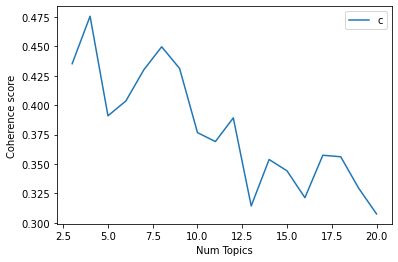

In [22]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of topic models
    coherence_values : Coherence values corresponding to the topic models with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = models.LsiModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

start1 = 3 
limit1 = 21
step1 = 1

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=start1, limit=limit1, step=step1)

x = range(start1, limit1, step1)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [24]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.4353
Num Topics = 4  has Coherence Value of 0.4757
Num Topics = 5  has Coherence Value of 0.391
Num Topics = 6  has Coherence Value of 0.4036
Num Topics = 7  has Coherence Value of 0.4301
Num Topics = 8  has Coherence Value of 0.4497
Num Topics = 9  has Coherence Value of 0.4313
Num Topics = 10  has Coherence Value of 0.3767
Num Topics = 11  has Coherence Value of 0.3691
Num Topics = 12  has Coherence Value of 0.3892
Num Topics = 13  has Coherence Value of 0.3143
Num Topics = 14  has Coherence Value of 0.3538
Num Topics = 15  has Coherence Value of 0.3442
Num Topics = 16  has Coherence Value of 0.3213
Num Topics = 17  has Coherence Value of 0.3574
Num Topics = 18  has Coherence Value of 0.3562
Num Topics = 19  has Coherence Value of 0.3295
Num Topics = 20  has Coherence Value of 0.3075


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### b. Build optimal model

In [25]:
optimal_model = model_list[8] # Index of preferred number of topics

model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=100))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[(0,
  '0.387*"court" + 0.269*"accuse" + 0.260*"appellant" + 0.226*"people" + '
  '0.217*"case" + 0.164*"trial" + 0.154*"crime" + 0.145*"victim" + '
  '0.143*"witness" + 0.123*"say" + 0.120*"evidence" + 0.118*"testimony" + '
  '0.116*"house" + 0.112*"rape" + 0.110*"time" + 0.109*"prosecution" + '
  '0.104*"wa" + 0.103*"act" + 0.102*"scra" + 0.095*"tsn" + 0.093*"penalty" + '
  '0.090*"pp" + 0.090*"person" + 0.088*"criminal" + 0.086*"follow" + '
  '0.082*"fact" + 0.081*"rule" + 0.076*"circumstance" + 0.074*"appeal" + '
  '0.073*"order" + 0.073*"commit" + 0.072*"police" + 0.072*"testify" + '
  '0.070*"decision" + 0.070*"law" + 0.069*"go" + 0.068*"charge" + '
  '0.068*"petitioner" + 0.067*"record" + 0.067*"present" + 0.066*"take" + '
  '0.065*"day" + 0.065*"death" + 0.064*"year" + 0.064*"sir" + 0.063*"defense" '
  '+ 0.063*"guilty" + 0.061*"place" + 0.061*"tell" + 0.060*"complainant" + '
  '0.060*"see" + 0.059*"hold" + 0.059*"information" + 0.059*"right" + '
  '0.058*"leave" + 0.056*"date"

In [33]:
type(optimal_model.print_topics(num_words=100))

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


list

In [34]:
num = np.array(optimal_model.print_topics(num_words=100))
num 

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


array([['0',
        '0.387*"court" + 0.269*"accuse" + 0.260*"appellant" + 0.226*"people" + 0.217*"case" + 0.164*"trial" + 0.154*"crime" + 0.145*"victim" + 0.143*"witness" + 0.123*"say" + 0.120*"evidence" + 0.118*"testimony" + 0.116*"house" + 0.112*"rape" + 0.110*"time" + 0.109*"prosecution" + 0.104*"wa" + 0.103*"act" + 0.102*"scra" + 0.095*"tsn" + 0.093*"penalty" + 0.090*"pp" + 0.090*"person" + 0.088*"criminal" + 0.086*"follow" + 0.082*"fact" + 0.081*"rule" + 0.076*"circumstance" + 0.074*"appeal" + 0.073*"order" + 0.073*"commit" + 0.072*"police" + 0.072*"testify" + 0.070*"decision" + 0.070*"law" + 0.069*"go" + 0.068*"charge" + 0.068*"petitioner" + 0.067*"record" + 0.067*"present" + 0.066*"take" + 0.065*"day" + 0.065*"death" + 0.064*"year" + 0.064*"sir" + 0.063*"defense" + 0.063*"guilty" + 0.061*"place" + 0.061*"tell" + 0.060*"complainant" + 0.060*"see" + 0.059*"hold" + 0.059*"information" + 0.059*"right" + 0.058*"leave" + 0.056*"date" + 0.053*"article" + 0.053*"incident" + 0.053*"give

In [31]:
# reshaped = num.reshape(22,22)
# reshaped

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [32]:
# l = optimal_model.print_topics(num_words=100)
# [i.split('+', 1)[0] for i in l]


/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [41]:
from pyLDAvis import gensim_models
pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lsimodel,corpus,dictionary)

/opt/anaconda3/lib/python3.8/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


NameError: name 'dictionary' is not defined